In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K

'''
Dataset: Particles
Dataset: Particles_Classes
Dataset: Particles_Names

array([b'MET_class_1', b'Four_Ele_class_2', b'Four_Mu_class_3',
       b'Ten_Jet_class_4'], dtype='|S16')
       
array([b'Pt', b'Eta', b'Phi', b'Class'], dtype='|S5')

shape = (n, 19, 4)
'''

files = ['background_for_training.h5',
         'Ato4l_lepFilter_13TeV_filtered.h5',
         'hChToTauNu_13TeV_PU20_filtered.h5',
         'hToTauTau_13TeV_PU20_filtered.h5',
         'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

data = []
for i in range(len(files)):
    with h5py.File(files[i], 'r') as hdf:
        if i == 0:
            data.append(hdf['Particles'][:100000])
        else:
            data.append(hdf['Particles'][:])
    print(data[i].shape)

data[1][2]

(100000, 19, 4)
(55969, 19, 4)
(760272, 19, 4)
(691283, 19, 4)
(340544, 19, 4)


array([[ 6.76132965,  0.        ,  1.15189862,  1.        ],
       [28.02878571,  0.0848856 , -1.33467388,  2.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 7.86102533,  0.0485602 ,  1.2370621 ,  3.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [41.65947342,  0.95587289, -2.99767089,  4.        ],
       [29.83676529,  0.91927922,  0.05157597,  4.        ],
       [28.80836487,  0.09456544, -1.33484852,  4.        ],
       [24.68841934, -1.10409391, -2.82231712,  4.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.

In [ ]:
def plot_data(data, obj):
    if obj == 'MET':
        k = 1
    elif obj == 'Ele':
        k = 2
    elif obj == 'Mu':
        k = 3
    elif obj == 'Jet':
        k = 4

    plt.figure(figsize=(7,5))

    for i in range(len(data)):
        plt.hist(data[i][:,:,0][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Pt [GeV]')
        plt.title(obj)
        plt.legend()
    plt.show()
    
    plt.figure(figsize=(7,5))
    for i in range(len(data)):
        plt.hist(data[i][:,:,1][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Eta')
        plt.title(obj)
        #plt.legend()
    plt.show()
    
    plt.figure(figsize=(7,5))
    for i in range(len(data)):
        plt.hist(data[i][:,:,2][data[i][:,:,3]==k], log=True, label=files[i], alpha=1, histtype='step',
                 density=True, bins=100)
        plt.xlabel('Phi')
        plt.title(obj)
        #plt.legend()
    plt.show()
    
plot_data(data, 'MET')
plot_data(data, 'Ele')
plot_data(data, 'Mu')
plot_data(data, 'Jet')

In [5]:
for i in range(len(data)):
    data[i] = np.reshape(data[i][:,:,:3], (data[i].shape[0], -1))

X = data[0]

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
del X_train_val

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

for i in range(1, 5):
    data[i] = scaler.transform(data[i])

X_train shape: (60000, 57)
X_val   shape: (20000, 57)
X_test  shape: (20000, 57)


In [ ]:
def build_autoencoder(input_dim=57):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(32, activation='relu')(input_layer)
    encoded = layers.Dense(16, activation='relu')(encoded)
    latent = layers.Dense(3, activation='relu')(encoded)
    
    decoded = layers.Dense(16, activation='relu')(latent)
    decoded = layers.Dense(32, activation='relu')(decoded)
    output_layer = layers.Dense(input_dim, activation='relu')(decoded)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005), loss='mse')
    return model

model_ae = build_autoencoder(input_dim=57)
model_ae.summary()

In [ ]:
history = model_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=20, batch_size=128)

plt.figure(figsize = (6,4))
axes = plt.subplot(1,1,1)
axes.plot(history.history['loss'], label = 'loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
def compute_mse_for_ae(model, x):
    reco = model.predict(x)
    mse = np.mean(np.square(x - reco), axis=1)
    return mse

score_x_test = compute_mse_for_ae(model_ae, X_test)
score_sig = []
for i in range(4):
    score_sig.append(compute_mse_for_ae(model_ae, data[i+1]))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(score_x_test, bins=50, alpha=0.5, label='Bkg', density=True)

for i, score_vals in enumerate(score_sig):
    plt.hist(score_vals, bins=50, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('MSE')
plt.xlim((0,10000))
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([score_x_test, score_sig[i]])
    labels = np.concatenate([np.zeros_like(score_x_test), np.ones_like(score_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()

In [38]:
class PlanarFlow(layers.Layer):
    def __init__(self, **kwargs):
        super(PlanarFlow, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.w = self.add_weight(name='w', shape=(self.input_dim,),
                                 initializer='random_normal', trainable=True)
        self.u = self.add_weight(name='u', shape=(self.input_dim,),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='b', shape=(1,),
                                 initializer='random_normal', trainable=True)
        super(PlanarFlow, self).build(input_shape)
    
    def call(self, inputs):
        # f(x) = x + u * h(w^T x + b)
        linear_term = tf.tensordot(inputs, self.w, axes=1) + self.b
        h = tf.tanh(linear_term)
        outputs = inputs + tf.expand_dims(h, -1) * self.u

        # det = 1 + u^T h'(w^T x + b) * w
        h_prime = 1 - tf.square(tf.tanh(linear_term))
        psi = tf.expand_dims(h_prime, -1) * self.w
        u_dot_psi = tf.reduce_sum(self.u * psi, axis=-1)
        log_det = tf.math.log(tf.abs(1 + u_dot_psi) + 1e-10)

        return outputs, log_det
    
class NormalizingFlowModel(Model):
    def __init__(self, num_flows=6, **kwargs):
        super(NormalizingFlowModel, self).__init__(**kwargs)
        self.dense1 = layers.Dense(32, activation=layers.LeakyReLU(alpha=0.1))
        self.dense2 = layers.Dense(16, activation=layers.LeakyReLU(alpha=0.1))
        self.dense3 = layers.Dense(3, activation=layers.LeakyReLU(alpha=0.1))
        self.flows = [PlanarFlow() for _ in range(num_flows)]
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        log_det_total = 0

        for flow in self.flows:
            x, log_det = flow(x)
            log_det_total += log_det

        return x, log_det_total
    
def base_log_prob(z):
    d = tf.cast(tf.shape(z)[-1], tf.float32)
    log_prob = -0.5 * (tf.reduce_sum(tf.square(z), axis=-1) + d * tf.math.log(2 * np.pi))
    return log_prob

def nll_loss(model, x):
    z, log_det_total = model(x)
    log_prob = base_log_prob(z) + log_det_total
    loss = -tf.reduce_mean(log_prob)
    return loss

Epoch 1/50, Loss: -6.3599
Epoch 2/50, Loss: -14.3652
Epoch 3/50, Loss: -16.5334
Epoch 4/50, Loss: -17.3043
Epoch 5/50, Loss: -17.8591
Epoch 6/50, Loss: -18.3438
Epoch 7/50, Loss: -1.5996
Epoch 8/50, Loss: -15.5467
Epoch 9/50, Loss: -18.4941
Epoch 10/50, Loss: -18.6476
Epoch 11/50, Loss: -18.9292
Epoch 12/50, Loss: -19.1846
Epoch 13/50, Loss: -19.3653
Epoch 14/50, Loss: -19.6106
Epoch 15/50, Loss: -11.9110
Epoch 16/50, Loss: -19.8103
Epoch 17/50, Loss: -19.9276
Epoch 18/50, Loss: -20.0763
Epoch 19/50, Loss: -20.2850
Epoch 20/50, Loss: -20.4715
Epoch 21/50, Loss: -13.0991
Epoch 22/50, Loss: -20.2173
Epoch 23/50, Loss: -20.6119
Epoch 24/50, Loss: -20.8213
Epoch 25/50, Loss: -14.2976
Epoch 26/50, Loss: -20.9357
Epoch 27/50, Loss: -21.0036
Epoch 28/50, Loss: -21.1363
Epoch 29/50, Loss: -8.3279
Epoch 30/50, Loss: -17.4018
Epoch 31/50, Loss: -20.9319
Epoch 32/50, Loss: -20.8592
Epoch 33/50, Loss: -20.6380
Epoch 34/50, Loss: -20.9379
Epoch 35/50, Loss: 21.7412
Epoch 36/50, Loss: -16.3047
Epoch

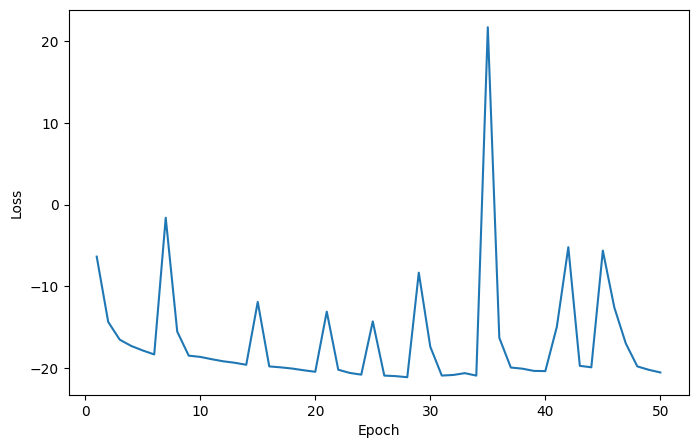

In [39]:
epochs = 50
batch_size = 128

model_nf = NormalizingFlowModel(num_flows=6)

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(batch_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)

epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            loss = nll_loss(model_nf, x_batch)
        grads = tape.gradient(loss, model_nf.trainable_variables)
        optimizer.apply_gradients(zip(grads, model_nf.trainable_variables))
        epoch_loss += loss.numpy()
        num_batches += 1
    avg_loss = epoch_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs+1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [40]:
def compute_nll_for_nf(model, data):
    z, log_det_total = model(data)
    log_prob = base_log_prob(z) + log_det_total
    nll = -log_prob.numpy()
    return nll

nll_x_test = compute_nll_for_nf(model_nf, X_test)

nll_sig = []
for i in range(4):
    nll_sig.append(compute_nll_for_nf(model_nf, data[i+1]))

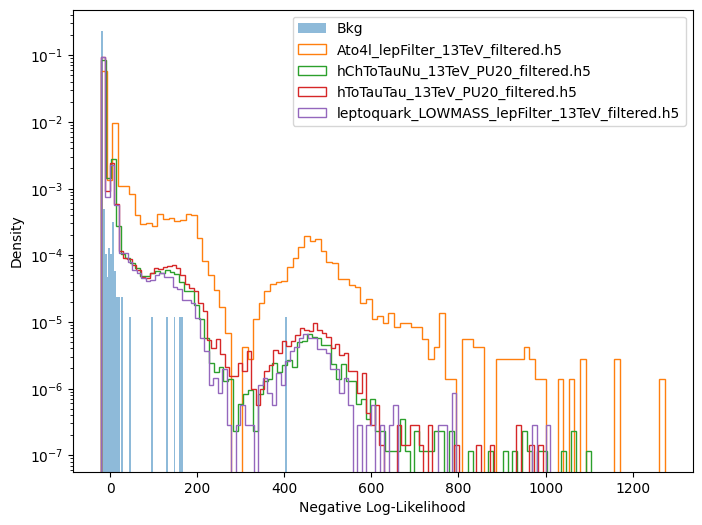

In [41]:
plt.figure(figsize=(8,6))
plt.hist(nll_x_test, bins=100, alpha=0.5, label='Bkg', density=True)

for i, nll_vals in enumerate(nll_sig):
    plt.hist(nll_vals, bins=100, label=f'{files[i+1]}', density=True, histtype='step')

plt.xlabel('Negative Log-Likelihood')
plt.ylabel('Density')
#plt.xlim((-100,1000))
plt.yscale('log')
plt.legend()
plt.show()

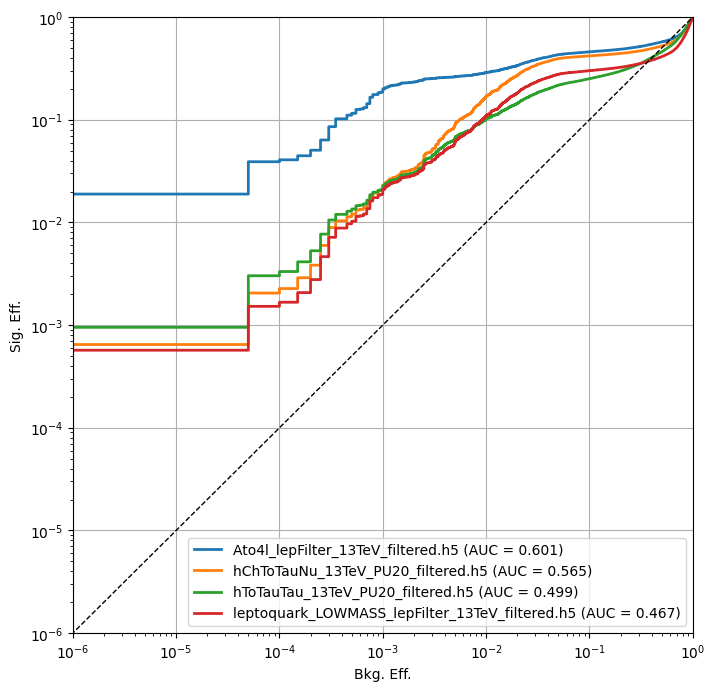

In [44]:
plt.figure(figsize=(8, 8))
for i in range(4):
    errors = np.concatenate([nll_x_test, nll_sig[i]])
    labels = np.concatenate([np.zeros_like(nll_x_test), np.ones_like(nll_sig[i])])
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{files[i+1]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Bkg. Eff.')
plt.ylabel('Sig. Eff.')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.ylim((1e-6,1))
plt.xlim((1e-6,1))
plt.grid(True)
plt.show()